In [18]:
TARGET = "DNI"

In [19]:
from pathlib import Path
import pickle
from matplotlib.pylab import Enum
import pandas as pd
from ForecastEvaluator import ForecastEvaluator
from _config import PKL_PROCESSED_STEP1_DTU_SOLAR_STATION
from data_loader import MyDataLoader
from my_config import MyConfig, load_config
from functools import reduce

# create enum class
class ModelType(Enum):
    PERSISTENCE = 1
    
    OLS = 2
    OLSwNIGHT = 3  # OLS but not removing nights
    
    OLSwSTATION = 4  # OLS with station features
    OLSwSTATIONwNIGHT = 5  # OLS with station features
    
    OLSwSTATIONwECMWF = 6  # OLS with ECMWF features
    OLSwSTATIONwECMWFwNIGHT = 7  # OLS with ECMWF features but not removing nights

    LSTM = 8
    LSTMwSTATION = 9  # LSTM with station features
    LSTMwSTATIONwECMWF = 10 # LSTM with station and ECMWF features
    
    



class ResultInstance:
    absolute_path: Path
    config: MyConfig
    df: pd.DataFrame
    metrics:dict[str, float]
    model: ModelType
    label:str
    color:str

    def __init__(self, absolute_path: Path):
        self.absolute_path = absolute_path
        self.config = load_config(absolute_path.parent / "config.json")
        n = absolute_path.parent.name
        if "OLS" in n and "STATION" in n and "ECMWF" in n and "NIGHT" in n:
            self.model = ModelType.OLSwSTATIONwECMWFwNIGHT
            self.label = "OLS + STATION + ECMWF + Night"
            self.color = "#FF4040"
        elif "OLS" in n and "STATION" in n and "ECMWF" in n:
            self.model = ModelType.OLSwSTATIONwECMWF
            self.label = "OLS + STATION + ECMWF"
            self.color = "#EA6676"
        elif "OLS" in n and "STATION" in n and "NIGHT" in n:
            self.model = ModelType.OLSwSTATIONwNIGHT
            self.label = "OLS + STATION + Night"
            self.color = "#FFBAAD"
        elif "OLS" in n and "STATION" in n:
            self.model = ModelType.OLSwSTATION
            self.label = "OLS + STATION"
            self.color = "#FFBB47"
        elif "OLS" in n and "NIGHT" in n:
            self.model = ModelType.OLSwNIGHT
            self.label = "OLS + Night"
            self.color = "#FF7F50"
        elif "OLS" in n:
            self.model = ModelType.OLS
            self.label = "OLS"
            self.color = "#FFD2A9"
        elif "LSTM" in n and "STATION" in n and "ECMWF" in n:
            self.model = ModelType.LSTMwSTATIONwECMWF
            self.label = "LSTM + STATION + ECMWF"
            self.color = "#9DC183"
        elif "LSTM" in n and "STATION" in n:
            self.model = ModelType.LSTMwSTATION
            self.label = "LSTM + STATION"
            self.color = "#74C365"
        elif "LSTM" in n:
            self.model = ModelType.LSTM
            self.label = "LSTM"
            self.color = "#0B6623"
        elif "PERSISTENCE" in n:
            self.model = ModelType.PERSISTENCE
            self.label = "PERSISTENCE"
            self.color = "#63C5DA"
        else:
            print(f"Unknown model type in file name: {absolute_path.parent.name} - Defaulting to LSTM.")
            self.model = ModelType.LSTM
            self.label = "LSTM (Default)"
            self.color = "#000000"

        with open(absolute_path, "rb") as f:
            self.df = pickle.load(f)
        

class Results:
    results = list[ResultInstance]
    truth: pd.DataFrame
    overlapping_indexes: list

    def __init__(self):
        self.results = []
        self.truth = pd.DataFrame()

    def load_truth(self, target_column: str):
        df = pd.read_pickle(PKL_PROCESSED_STEP1_DTU_SOLAR_STATION)
        df = df[target_column].to_frame()
        self.overlapping_indexes = list(set(df.index)) # Initialize with all indexes from the truth data
        self.truth = df.copy()
        del df



    def match_indexes(self):
        """
        Matches the indexes of all results with the truth data.
        This ensures that all results only contain the indexes that are present in all results.
        """
        # 1) compute a single common Index by intersecting all DataFrame.index objects
        all_indexes = [res.df.index for res in self.results] + [self.truth.index]
        common_idx = reduce(lambda a, b: a.intersection(b), all_indexes)
        
        # 2) sort the resulting Index once (so we don’t have to sort each DataFrame separately)
        common_idx = common_idx.sort_values()

        # 3) store it (as a list, if you still need it that way)
        self.overlapping_indexes = common_idx.tolist()

        # 4) reindex each result (and truth) in one line, preserving order
        for res in self.results:
            res.df = res.df.loc[common_idx]

        self.truth = self.truth.loc[common_idx]


PATH_BASE = Path(r'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting')

results = Results()
results.load_truth(TARGET)

In [20]:
results.results.clear()  # Clear any existing results
include_any_keyword_list = []
must_include_keyword_list = []#['STATION']
exclude_keyword_list = []#['ECMWF']
for file in (PATH_BASE / 'checkpoint').rglob('predictions.pkl'):
    if (include_any_keyword_list is not None) and (len(include_any_keyword_list) > 0):
        if not any(keyword in str(file) for keyword in include_any_keyword_list):
            continue
    if (must_include_keyword_list is not None) and (len(must_include_keyword_list) > 0):
        if any(keyword in str(file) for keyword in exclude_keyword_list):
            continue
    if (exclude_keyword_list is not None) and (len(exclude_keyword_list) > 0):
        if not all(keyword in str(file) for keyword in must_include_keyword_list):
            continue
    print(f"Loading {file}")
    results.results.append(ResultInstance(file))

for result in results.results:
    print(f"Loaded {result.absolute_path.parent.name} with {len(result.df.index)} rows")


Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\11_PERSISTENCE_DNI_LAG_1_2020\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\12_PERSISTENCE_DNI_LAG_60_2020\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250611-164753_LSTM_DNI_STATION_ECMWF_CELL_1_1_32\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\21_OLS_DNI_LAG_1_2020\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\22_OLS_DNI_LAG_60_2020\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\23_OLS_DNI_LAG_60_1440_2880_2020\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\24_OLS_DNI_STATION_2020\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\25_OLS_DNI_STATION_ECMWF_CELL_1_2020\predictions.pkl
Loading D:\Je

In [21]:
results.match_indexes()

In [22]:
for result in results.results:
    print(f"After matching indexes, {result.absolute_path.parent.name} has {len(result.df.index)} rows")

After matching indexes, 11_PERSISTENCE_DNI_LAG_1_2020 has 222720 rows
After matching indexes, 12_PERSISTENCE_DNI_LAG_60_2020 has 222720 rows
After matching indexes, 20250611-164753_LSTM_DNI_STATION_ECMWF_CELL_1_1_32 has 222720 rows
After matching indexes, 21_OLS_DNI_LAG_1_2020 has 222720 rows
After matching indexes, 22_OLS_DNI_LAG_60_2020 has 222720 rows
After matching indexes, 23_OLS_DNI_LAG_60_1440_2880_2020 has 222720 rows
After matching indexes, 24_OLS_DNI_STATION_2020 has 222720 rows
After matching indexes, 25_OLS_DNI_STATION_ECMWF_CELL_1_2020 has 222720 rows
After matching indexes, 27_OLS_DNI_STATION_ECMWF_ALL_2020 has 222720 rows
After matching indexes, 34_20250611-151546_LSTM_DNI_STATION_1_32_2020 has 222720 rows
After matching indexes, 36_20250606-105408_LSTM_DNI_STATION_ECMWF_CELL_1_3_32_2020 has 222720 rows
After matching indexes, 37_20250602-172507_LSTM_DNI_STATION_ECMWF_ALL_1_32_2020 has 222720 rows


In [23]:
class Comparison:
    df: pd.DataFrame
    truth: pd.DataFrame
    error_df: pd.DataFrame
    results: Results

    def __init__(self, results: Results):
        self.df = pd.DataFrame(index=results.truth.index)
        self.truth = results.truth.copy()
        self.results = results

    def compute_errors(self, target_column: str):
        self.error_df = pd.DataFrame(index=self.df.index)
        for column in self.df.columns:
            self.error_df[column] = self.truth[target_column] - self.df[column]
    
    def add_lstm_result(self, step_index_target_column: int):
        for result in self.results.results:
            if result.model == ModelType.LSTM  or result.model == ModelType.LSTMwSTATION or result.model == ModelType.LSTMwSTATIONwECMWF:
                self.df[result.absolute_path.parent.name] = result.df[step_index_target_column]

    def add_ols_result(self):
        for result in self.results.results:
            if result.model == ModelType.OLS or result.model == ModelType.OLSwNIGHT or result.model == ModelType.OLSwSTATION or result.model == ModelType.OLSwSTATIONwNIGHT or result.model == ModelType.OLSwSTATIONwECMWF or result.model == ModelType.OLSwSTATIONwECMWFwNIGHT:
                self.df[result.absolute_path.parent.name] = result.df[result.config.name]

    def add_persistence_result(self):
        for result in self.results.results:
            if result.model == ModelType.PERSISTENCE:
                self.df[result.absolute_path.parent.name] = result.df[result.config.name]
        



comparsion = Comparison(results)
comparsion.add_lstm_result(59)  # Assuming the first column is the target column for LSTM
comparsion.add_ols_result()
comparsion.add_persistence_result()
display(comparsion.df.head())
display(comparsion.truth.head())

,20250611-164753_LSTM_DNI_STATION_ECMWF_CELL_1_1_32,34_20250611-151546_LSTM_DNI_STATION_1_32_2020,36_20250606-105408_LSTM_DNI_STATION_ECMWF_CELL_1_3_32_2020,37_20250602-172507_LSTM_DNI_STATION_ECMWF_ALL_1_32_2020,21_OLS_DNI_LAG_1_2020,22_OLS_DNI_LAG_60_2020,23_OLS_DNI_LAG_60_1440_2880_2020,24_OLS_DNI_STATION_2020,25_OLS_DNI_STATION_ECMWF_CELL_1_2020,27_OLS_DNI_STATION_ECMWF_ALL_2020,11_PERSISTENCE_DNI_LAG_1_2020,12_PERSISTENCE_DNI_LAG_60_2020
2024-01-01 07:43:00,3.888432,19.344492,20.668544,33.906911,0.0,0.0,0.003187,10.166383,-24.499111,-56.742708,0.0,0.0
2024-01-01 07:44:00,3.342654,19.628936,20.670074,34.628553,0.0,0.0,0.001952,7.761325,-26.692508,-56.814447,0.0,0.0
2024-01-01 07:45:00,3.444744,20.983527,20.699762,34.668684,0.0,0.0,0.003910,13.730608,-22.394823,-54.875285,0.0,0.0
2024-01-01 07:46:00,3.131820,20.673378,20.749893,35.247702,0.0,0.0,0.004253,15.632193,-21.002905,-53.850732,0.0,0.0
2024-01-01 07:47:00,2.851732,19.822904,20.800950,35.373632,0.0,0.0,0.006069,17.997129,-18.520256,-52.687044,0.0,0.0


,DNI
2024-01-01 07:43:00,0.0
2024-01-01 07:44:00,0.0
2024-01-01 07:45:00,0.0
2024-01-01 07:46:00,0.0
2024-01-01 07:47:00,0.0


In [24]:
comparsion.compute_errors(TARGET)
comparsion.error_df.head()

,20250611-164753_LSTM_DNI_STATION_ECMWF_CELL_1_1_32,34_20250611-151546_LSTM_DNI_STATION_1_32_2020,36_20250606-105408_LSTM_DNI_STATION_ECMWF_CELL_1_3_32_2020,37_20250602-172507_LSTM_DNI_STATION_ECMWF_ALL_1_32_2020,21_OLS_DNI_LAG_1_2020,22_OLS_DNI_LAG_60_2020,23_OLS_DNI_LAG_60_1440_2880_2020,24_OLS_DNI_STATION_2020,25_OLS_DNI_STATION_ECMWF_CELL_1_2020,27_OLS_DNI_STATION_ECMWF_ALL_2020,11_PERSISTENCE_DNI_LAG_1_2020,12_PERSISTENCE_DNI_LAG_60_2020
2024-01-01 07:43:00,-3.888432,-19.344492,-20.668544,-33.906911,0.0,0.0,-0.003187,-10.166383,24.499111,56.742708,0.0,0.0
2024-01-01 07:44:00,-3.342654,-19.628936,-20.670074,-34.628553,0.0,0.0,-0.001952,-7.761325,26.692508,56.814447,0.0,0.0
2024-01-01 07:45:00,-3.444744,-20.983527,-20.699762,-34.668684,0.0,0.0,-0.003910,-13.730608,22.394823,54.875285,0.0,0.0
2024-01-01 07:46:00,-3.131820,-20.673378,-20.749893,-35.247702,0.0,0.0,-0.004253,-15.632193,21.002905,53.850732,0.0,0.0
2024-01-01 07:47:00,-2.851732,-19.822904,-20.800950,-35.373632,0.0,0.0,-0.006069,-17.997129,18.520256,52.687044,0.0,0.0


In [25]:
comparsion.error_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222720 entries, 2024-01-01 07:43:00 to 2024-12-29 12:24:00
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   20250611-164753_LSTM_DNI_STATION_ECMWF_CELL_1_1_32          222720 non-null  float64
 1   34_20250611-151546_LSTM_DNI_STATION_1_32_2020               222720 non-null  float64
 2   36_20250606-105408_LSTM_DNI_STATION_ECMWF_CELL_1_3_32_2020  222720 non-null  float64
 3   37_20250602-172507_LSTM_DNI_STATION_ECMWF_ALL_1_32_2020     222720 non-null  float64
 4   21_OLS_DNI_LAG_1_2020                                       222720 non-null  float64
 5   22_OLS_DNI_LAG_60_2020                                      222720 non-null  float64
 6   23_OLS_DNI_LAG_60_1440_2880_2020                            222720 non-null  float64
 7   24_OLS_DNI_STATION_2020                 

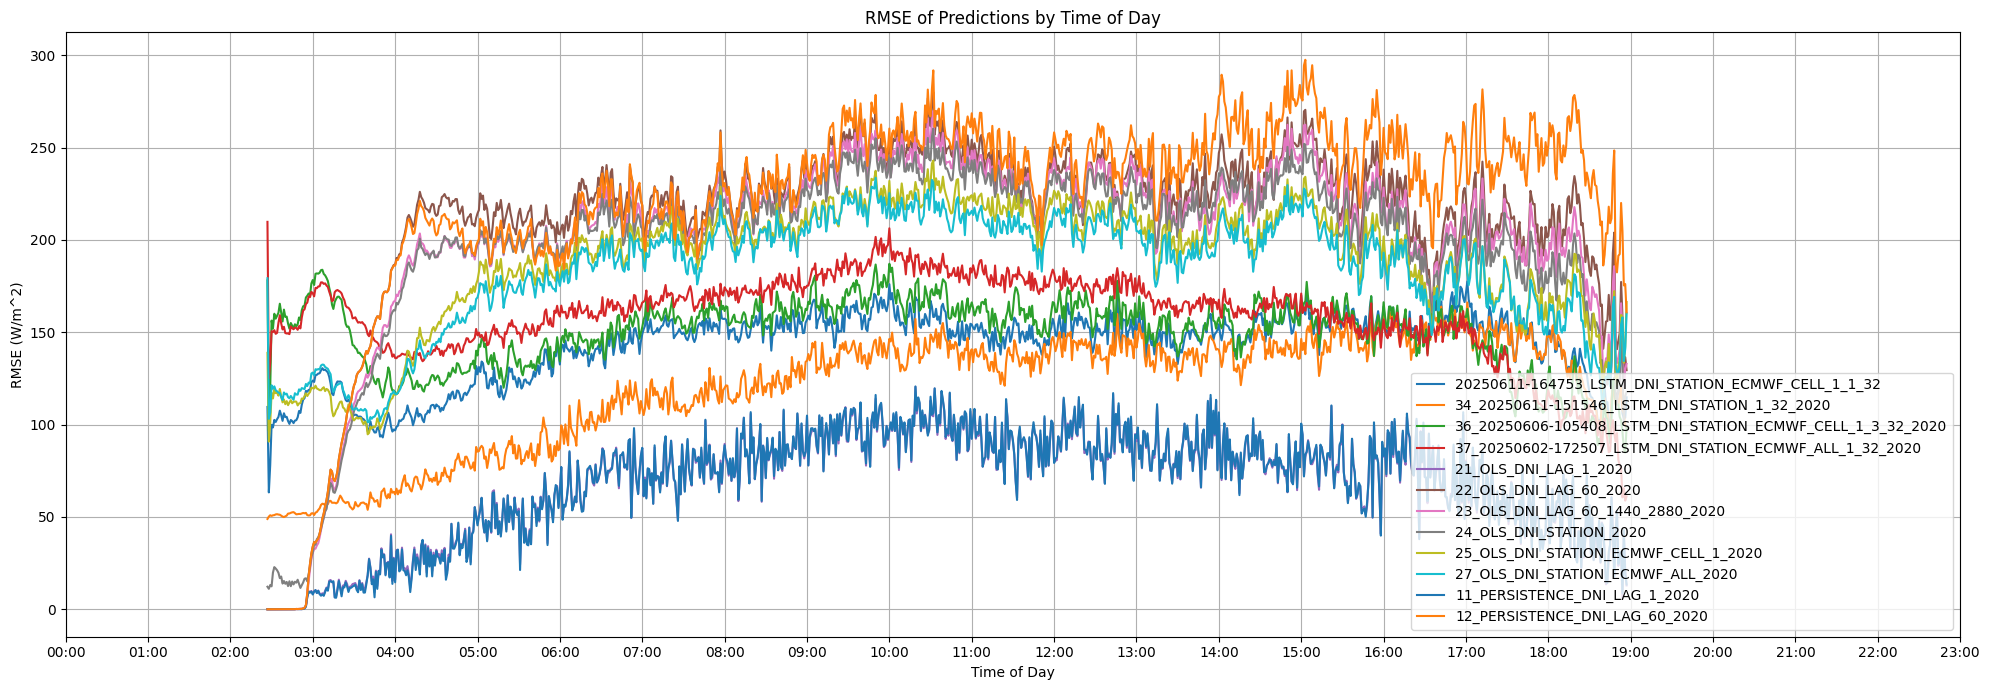

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 7))
comparsion.error_df['minute_of_day'] = comparsion.error_df.index.hour * 60 + comparsion.error_df.index.minute
for col in comparsion.error_df.columns:
    if col == 'minute_of_day':
        continue

    rmse_values = comparsion.error_df.groupby('minute_of_day')[col].apply(lambda x: (x**2).mean()**0.5)
    rmse_values.plot(ax=ax, ylabel='RMSE (W/m^2)', xlabel='Time of Day', label=col)
comparsion.error_df.drop(columns=['minute_of_day'], inplace=True)

ax.set_xticks(range(0, 1440, 60))  # Every hour
ax.set_xticklabels([f"{i // 60:02d}:{i % 60:02d}" for i in range(0, 1440, 60)], rotation=0)
ax.legend()
plt.title('RMSE of Predictions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('RMSE (W/m^2)')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

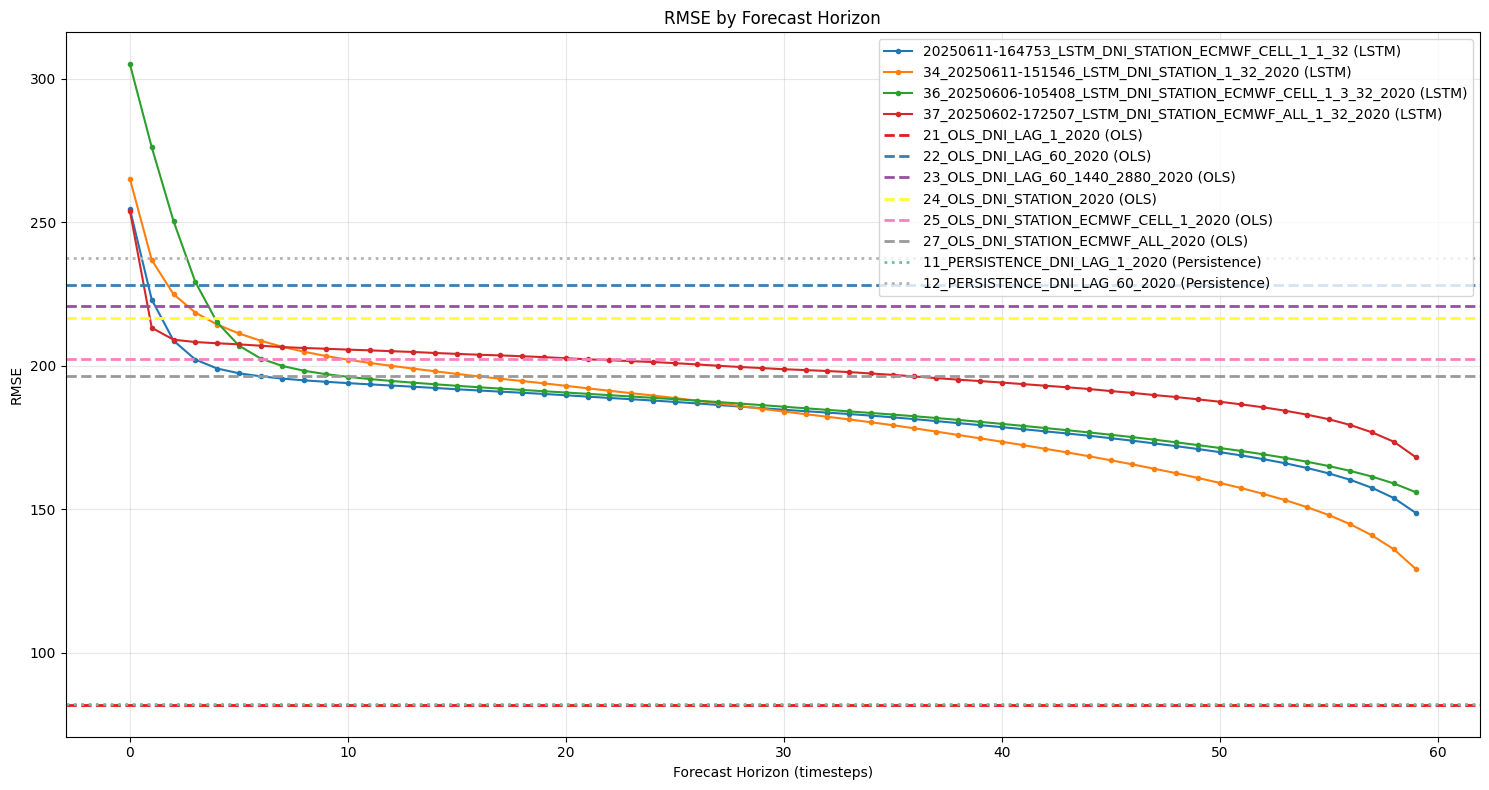

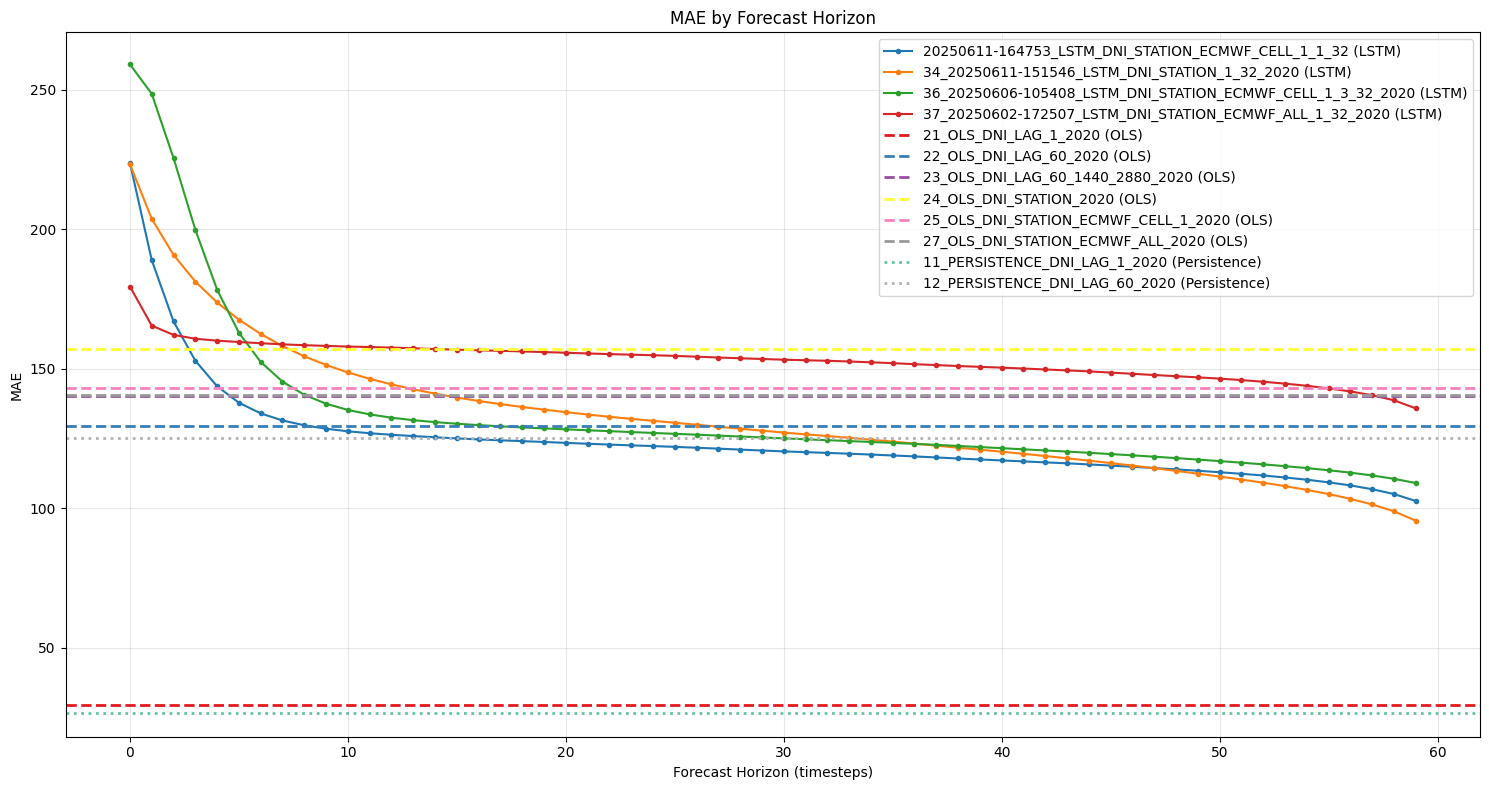

In [27]:
import numpy as np
def plot_model_metric_by_horizon(
    results: Results,
    target_key: str,
    metric_fn,
    metric_name: str,
    lstm_horizons: int = 60
):
    """
    Compute and plot a given metric (e.g. MAE, RMSE) for:
      • LSTM models (per‐horizon, 0..lstm_horizons−1)
      • OLS models (single value, plotted as horizontal line)
      • Persistence models (single value, horizontal line)

    Arguments:
        results       : ResultsContainer holding:
                          - results.results: list of Result objects
                          - results.truth[target_key]: pandas Series or array of true values
        target_key    : string key/column name in results.truth (e.g. 'TARGET')
        metric_fn     : function(truth_array, pred_array) → scalar metric
                        (e.g. MAE = lambda t,p: np.mean(np.abs(t-p)) )
        metric_name   : string, e.g. "MAE" or "RMSE". Used in labels/prints.
        lstm_horizons : int, number of horizons (default 60) for LSTM

    Returns:
        None. Displays a matplotlib figure and prints out summary stats.
    """
    # 1) Compute metric for each LSTM model per horizon:
    lstm_metric_by_timestep = {}
    for result in results.results:
        if result.model == ModelType.LSTM or result.model == ModelType.LSTMwSTATION or result.model == ModelType.LSTMwSTATIONwECMWF:
            model_name = result.absolute_path.parent.name
            mae_values = []
            for horizon in range(lstm_horizons):
                preds = result.df[horizon]
                truth_vals = results.truth[target_key]
                score = metric_fn(truth_vals.values, preds.values)
                mae_values.append(score)
            lstm_metric_by_timestep[model_name] = np.array(mae_values)

    # 2) Compute single metric for OLS and Persistence:
    ols_metric = {}
    persistence_metric = {}
    for result in results.results:
        if result.model == ModelType.OLS or result.model == ModelType.OLSwNIGHT or \
           result.model == ModelType.OLSwSTATION or result.model == ModelType.OLSwSTATIONwNIGHT or \
              result.model == ModelType.OLSwSTATIONwECMWF or result.model == ModelType.OLSwSTATIONwECMWFwNIGHT:
            model_name = result.absolute_path.parent.name
            preds = result.df[result.config.name]
            truth_vals = results.truth[target_key]
            score = metric_fn(truth_vals.values, preds.values)
            ols_metric[model_name] = score
        elif result.model == ModelType.PERSISTENCE:
            model_name = result.absolute_path.parent.name
            preds = result.df[result.config.name]
            truth_vals = results.truth[target_key]
            score = metric_fn(truth_vals.values, preds.values)
            persistence_metric[model_name] = score

    # 3) Plot everything
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(15, 8))

    # LSTM per‐horizon curves
    for model_name, metric_vals in lstm_metric_by_timestep.items():
        ax.plot(
            range(lstm_horizons),
            metric_vals,
            label=f"{model_name} (LSTM)",
            marker="o",
            markersize=3,
        )

    # OLS horizontal lines with different colors
    ols_colors = plt.cm.Set1(np.linspace(0, 1, len(ols_metric)))
    for i, (model_name, val) in enumerate(ols_metric.items()):
        ax.axhline(
            y=val,
            label=f"{model_name} (OLS)",
            linestyle="--",
            linewidth=2,
            color=ols_colors[i]
        )

    # Persistence horizontal lines with different colors
    persistence_colors = plt.cm.Set2(np.linspace(0, 1, len(persistence_metric)))
    for i, (model_name, val) in enumerate(persistence_metric.items()):
        ax.axhline(
            y=val,
            label=f"{model_name} (Persistence)",
            linestyle=":",
            linewidth=2,
            color=persistence_colors[i]
        )

    ax.set_xlabel("Forecast Horizon (timesteps)")
    ax.set_ylabel(f"{metric_name}")
    ax.set_title(f"{metric_name} by Forecast Horizon")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # # 4) Print summaries
    # # LSTM summary
    # if lstm_metric_by_timestep:
    #     print(f"LSTM {metric_name} by timestep:")
    #     for model_name, vals in lstm_metric_by_timestep.items():
    #         print(
    #             f"  {model_name}: "
    #             f"Min={vals.min():.4f}, Max={vals.max():.4f}, Mean={vals.mean():.4f}"
    #         )
    # else:
    #     print(f"No LSTM models found to compute {metric_name}.")

    # # OLS summary
    # if ols_metric:
    #     print(f"\nOLS {metric_name}:")
    #     for model_name, val in ols_metric.items():
    #         print(f"  {model_name}: {val:.4f}")
    # else:
    #     print(f"\nNo OLS models found to compute {metric_name}.")

    # # Persistence summary
    # if persistence_metric:
    #     print(f"\nPersistence {metric_name}:")
    #     for model_name, val in persistence_metric.items():
    #         print(f"  {model_name}: {val:.4f}")
    # else:
    #     print(f"\nNo Persistence models found to compute {metric_name}.")



plot_model_metric_by_horizon(
    results=results,
    target_key=TARGET,
    metric_fn=ForecastEvaluator.compute_rmse,
    metric_name="RMSE",
    lstm_horizons=60
)


plot_model_metric_by_horizon(
    results=results,
    target_key=TARGET,
    metric_fn=ForecastEvaluator.compute_mae,
    metric_name="MAE",
    lstm_horizons=60
)

# Sample plot predictions

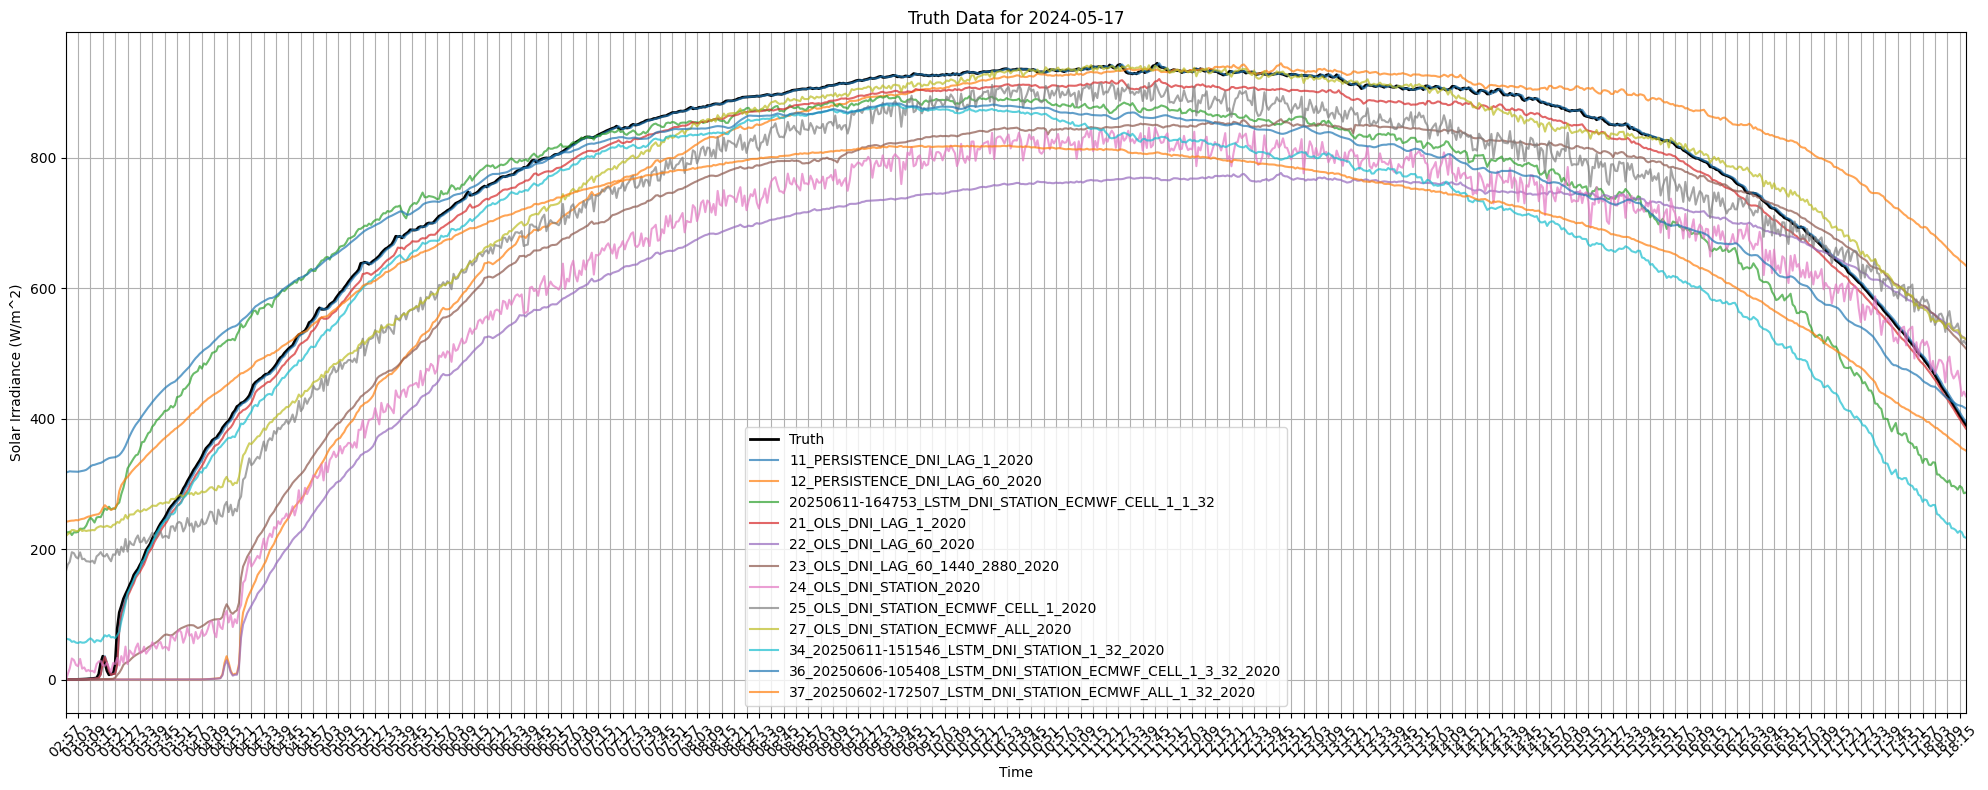

In [40]:
# Plot the truth data for a random date
import random
random_date = random.choice(results.truth.index).strftime('%Y-%m-%d')
truth_data = results.truth.loc[random_date]
plt.figure(figsize=(20, 8))
plt.plot(truth_data.index, truth_data.values, label='Truth', color='black', linewidth=2)
plt.title(f'Truth Data for {random_date}')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance (W/m^2)')
plt.xticks(rotation=45)
# human readable x-axis in format HH:MM
plt.xticks(truth_data.index[::6], [t.strftime('%H:%M') for t in truth_data.index[::6]], rotation=45)
# limit x-axis to the range of the truth data
plt.xlim(truth_data.index.min(), truth_data.index.max())

# Plot each model's predictions
for result in results.results:
    data = result.df.loc[random_date]
    if 'LSTM' in result.label:
        plt.plot(data.index, data.loc[:, 59], label=result.absolute_path.parent.name, alpha=0.7)
    elif 'OLS' in result.label:
        plt.plot(data.index, data[result.config.name], label=result.absolute_path.parent.name, alpha=0.7)
    elif result.model == ModelType.PERSISTENCE:
        plt.plot(data.index, data[result.config.name], label=result.absolute_path.parent.name, alpha=0.7)

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



# Autocorrelation


In [29]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.stats.stattools import durbin_watson
# from statsmodels.stats.diagnostic import acorr_ljungbox

# # Compute residuals using the correct column names
# df = model_lstm_df.copy()
# df['residual'] = df['Error']

# # Compute autocorrelation values for the residuals up to lag 20
# from statsmodels.tsa.stattools import acf
# acf_values = acf(df['residual'], nlags=60, fft=True)
# lags = list(range(len(acf_values)))
# acf_df = pd.DataFrame({'lag': lags, 'acf': acf_values})
# # plot ACF values
# fig, ax = plt.subplots(figsize=(12, 6))
# acf_df.plot(x='lag', y='acf', kind='bar', ax=ax, legend=False)
# ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
# ax.set_title('Autocorrelation Function (ACF) of Model Residuals')
# ax.set_xlabel('Lag')
# ax.set_ylabel('ACF Value')
# plt.xticks(rotation=45)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


In [30]:
import numpy as np
import pandas as pd


def create_summary_metrics_table(results: Results, target_key: str):
    """
    Create a comprehensive summary table with MSE, MAE, RMSE, and MAPE for all models.
    """
    summary_data = []
    truth_values = results.truth[target_key].values
    forecast_evaluator = ForecastEvaluator()

    for result in results.results:
        model_name = result.absolute_path.parent.name
        model_type = result.model.name

        if 'LSTM' in result.label:
            # For LSTM, we'll use the final horizon (59) as the main metric
            # and also provide average across all horizons
            pred_values = result.df[59].values

            # Add main entry for final horizon
            summary_data.append({
                'Model': model_name,
                'Type': model_type,
                'Color': result.color,
                'Label': result.label,
                'Horizon': 'Final (59)'
            })
            metrics = forecast_evaluator.evaluate_all(truth_values, pred_values)
            for metric, val in metrics.items():
                summary_data[-1][metric] = val


            # # Calculate average metrics across all horizons
            # all_horizon_metrics = []
            # for horizon in range(60):  # Assuming 60 horizons
            #     if horizon in result.df.columns:
            #         pred_vals = result.df[horizon].values
            #         horizon_metrics = forecast_evaluator.evaluate_all(truth_values, pred_vals)
            #         all_horizon_metrics.append(horizon_metrics)
            #
            # if all_horizon_metrics:
            #     avg_metrics = {
            #         'MSE': np.mean([m['MSE'] for m in all_horizon_metrics if not np.isnan(m['MSE'])]),
            #         'MAE': np.mean([m['MAE'] for m in all_horizon_metrics if not np.isnan(m['MAE'])]),
            #         'RMSE': np.mean([m['RMSE'] for m in all_horizon_metrics if not np.isnan(m['RMSE'])]),
            #         'MAPE': np.mean([m['MAPE'] for m in all_horizon_metrics if not np.isnan(m['MAPE'])])
            #     }
            #
            #     summary_data.append({
            #         'Model': model_name,
            #         'Type': model_type,
            #         'Horizon': 'Average (0-59)',
            #         'MSE': avg_metrics['MSE'],
            #         'MAE': avg_metrics['MAE'],
            #         'RMSE': avg_metrics['RMSE'],
            #         'MAPE': avg_metrics['MAPE']
            #     })

        elif 'OLS' in result.label or 'PERSISTENCE' in result.label:
            pred_values = result.df[result.config.name].values

            summary_data.append({
                'Model': model_name,
                'Type': model_type,
                'Color': result.color,
                'Label': result.label,
                'Horizon': 'N/A'
            })
            metrics = forecast_evaluator.evaluate_all(truth_values, pred_values)
            for metric, val in metrics.items():
                summary_data[-1][metric] = val


    # Create DataFrame and format
    summary_df = pd.DataFrame(summary_data)

    # Round numerical columns for better readability
    numeric_cols = forecast_evaluator.available_metrics()
    summary_df[numeric_cols] = summary_df[numeric_cols].round(4)

    return summary_df


# Generate the summary table
summary_table = create_summary_metrics_table(results, TARGET)

print("=" * 80)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print(f"Target Variable: {TARGET}")
print(f"Number of Models: {len(results.results)}")
print(f"Number of Data Points: {len(results.truth)}")
print("=" * 80)

# Display the table
display(summary_table)

# Also create a more compact view showing only the main metrics for each model
print("\n" + "=" * 80)
print("COMPACT SUMMARY (Main Metrics Only)")
print("=" * 80)

# For LSTM models, show only the final horizon metrics
compact_data = []
for _, row in summary_table.iterrows():
    if row['Type'] == 'LSTM' and row['Horizon'] == 'Final (59)':
        compact_data.append(row)
    elif row['Type'] in ['OLS', 'PERSISTENCE']:
        compact_data.append(row)

compact_df = pd.DataFrame(compact_data)
compact_df = compact_df.drop('Horizon', axis=1)  # Remove horizon column for cleaner view

display(compact_df)

# Find best performing models for each metric
print("\n" + "=" * 80)
print("BEST PERFORMING MODELS BY METRIC")
print("=" * 80)

for metric in ['MSE', 'MAE', 'RMSE', 'MAPE']:
    best_idx = compact_df[metric].idxmin()
    best_model = compact_df.loc[best_idx]
    print(f"{metric:>4}: {best_model['Model']} ({best_model['Type']}) - {best_model[metric]:.4f}")

MODEL PERFORMANCE SUMMARY
Target Variable: DNI
Number of Models: 12
Number of Data Points: 222720


,Model,Type,Color,Label,Horizon,MSE,RMSE,MAE,MAPE,R2,NMAE,NRMSE,Skill Score,MBE
0,11_PERSISTENCE_DNI_LAG_1_2020,PERSISTENCE,#63C5DA,PERSISTENCE,N/A,6782.7110,82.3572,26.5710,110.3252,0.9338,0.0272,0.0843,0.9338,-0.1320
1,12_PERSISTENCE_DNI_LAG_60_2020,PERSISTENCE,#63C5DA,PERSISTENCE,N/A,56392.7804,237.4716,125.2569,7153.3788,0.4493,0.1282,0.2431,0.4493,-11.5918
2,20250611-164753_LSTM_DNI_STATION_ECMWF_CELL_1_...,LSTMwSTATIONwECMWF,#9DC183,LSTM + STATION + ECMWF,Final (59),22141.4380,148.8000,102.6610,23820.3261,0.7838,0.1051,0.1523,0.7838,-8.9315
3,21_OLS_DNI_LAG_1_2020,OLS,#FFD2A9,OLS,N/A,6714.9624,81.9449,29.6580,108.1785,0.9344,0.0304,0.0839,0.9344,-6.2779
4,22_OLS_DNI_LAG_60_2020,OLS,#FFD2A9,OLS,N/A,52154.5479,228.3737,129.5882,5885.8379,0.4907,0.1326,0.2337,0.4907,-52.3568
5,23_OLS_DNI_LAG_60_1440_2880_2020,OLS,#FFD2A9,OLS,N/A,48763.8419,220.8254,140.4236,25217.7599,0.5238,0.1437,0.2260,0.5238,-26.0076
6,24_OLS_DNI_STATION_2020,OLSwSTATION,#FFBB47,OLS + STATION,N/A,47013.0188,216.8249,157.1011,44500.2757,0.5409,0.1608,0.2219,0.5409,-0.4211
7,25_OLS_DNI_STATION_ECMWF_CELL_1_2020,OLSwSTATIONwECMWF,#EA6676,OLS + STATION + ECMWF,N/A,40986.3015,202.4507,143.2435,37150.1482,0.5997,0.1466,0.2072,0.5997,-1.0537
8,27_OLS_DNI_STATION_ECMWF_ALL_2020,OLSwSTATIONwECMWF,#EA6676,OLS + STATION + ECMWF,N/A,38638.4118,196.5666,140.6566,40063.7621,0.6227,0.1440,0.2012,0.6227,2.0328
9,34_20250611-151546_LSTM_DNI_STATION_1_32_2020,LSTMwSTATION,#74C365,LSTM + STATION,Final (59),16709.4817,129.2652,95.6160,31793.4601,0.8368,0.0979,0.1323,0.8368,-2.9699



COMPACT SUMMARY (Main Metrics Only)


,Model,Type,Color,Label,MSE,RMSE,MAE,MAPE,R2,NMAE,NRMSE,Skill Score,MBE
0,11_PERSISTENCE_DNI_LAG_1_2020,PERSISTENCE,#63C5DA,PERSISTENCE,6782.7110,82.3572,26.5710,110.3252,0.9338,0.0272,0.0843,0.9338,-0.1320
1,12_PERSISTENCE_DNI_LAG_60_2020,PERSISTENCE,#63C5DA,PERSISTENCE,56392.7804,237.4716,125.2569,7153.3788,0.4493,0.1282,0.2431,0.4493,-11.5918
3,21_OLS_DNI_LAG_1_2020,OLS,#FFD2A9,OLS,6714.9624,81.9449,29.6580,108.1785,0.9344,0.0304,0.0839,0.9344,-6.2779
4,22_OLS_DNI_LAG_60_2020,OLS,#FFD2A9,OLS,52154.5479,228.3737,129.5882,5885.8379,0.4907,0.1326,0.2337,0.4907,-52.3568
5,23_OLS_DNI_LAG_60_1440_2880_2020,OLS,#FFD2A9,OLS,48763.8419,220.8254,140.4236,25217.7599,0.5238,0.1437,0.2260,0.5238,-26.0076



BEST PERFORMING MODELS BY METRIC
 MSE: 21_OLS_DNI_LAG_1_2020 (OLS) - 6714.9624
 MAE: 11_PERSISTENCE_DNI_LAG_1_2020 (PERSISTENCE) - 26.5710
RMSE: 21_OLS_DNI_LAG_1_2020 (OLS) - 81.9449
MAPE: 21_OLS_DNI_LAG_1_2020 (OLS) - 108.1785


In [31]:
report_df = summary_table.copy()
report_df.drop(columns=['Horizon'], inplace=True)  # Remove Horizon column for cleaner view
# for i, name in enumerate(report_df['Model']):
#     report_df.at[i, 'Model'] = '_'.join(name.split('_')[1:])

# sort by rmse and then by mae
report_df = report_df.sort_values(by=['Type','RMSE', 'MAE'], ascending=True)
report_df


,Model,Type,Color,Label,MSE,RMSE,MAE,MAPE,R2,NMAE,NRMSE,Skill Score,MBE
9,34_20250611-151546_LSTM_DNI_STATION_1_32_2020,LSTMwSTATION,#74C365,LSTM + STATION,16709.4817,129.2652,95.6160,31793.4601,0.8368,0.0979,0.1323,0.8368,-2.9699
2,20250611-164753_LSTM_DNI_STATION_ECMWF_CELL_1_...,LSTMwSTATIONwECMWF,#9DC183,LSTM + STATION + ECMWF,22141.4380,148.8000,102.6610,23820.3261,0.7838,0.1051,0.1523,0.7838,-8.9315
10,36_20250606-105408_LSTM_DNI_STATION_ECMWF_CELL...,LSTMwSTATIONwECMWF,#9DC183,LSTM + STATION + ECMWF,24342.8393,156.0219,109.1110,30391.2631,0.7623,0.1117,0.1597,0.7623,9.0345
11,37_20250602-172507_LSTM_DNI_STATION_ECMWF_ALL_...,LSTMwSTATIONwECMWF,#9DC183,LSTM + STATION + ECMWF,28296.4112,168.2154,135.8683,51762.4768,0.7237,0.1391,0.1722,0.7237,27.6226
3,21_OLS_DNI_LAG_1_2020,OLS,#FFD2A9,OLS,6714.9624,81.9449,29.6580,108.1785,0.9344,0.0304,0.0839,0.9344,-6.2779
5,23_OLS_DNI_LAG_60_1440_2880_2020,OLS,#FFD2A9,OLS,48763.8419,220.8254,140.4236,25217.7599,0.5238,0.1437,0.2260,0.5238,-26.0076
4,22_OLS_DNI_LAG_60_2020,OLS,#FFD2A9,OLS,52154.5479,228.3737,129.5882,5885.8379,0.4907,0.1326,0.2337,0.4907,-52.3568
6,24_OLS_DNI_STATION_2020,OLSwSTATION,#FFBB47,OLS + STATION,47013.0188,216.8249,157.1011,44500.2757,0.5409,0.1608,0.2219,0.5409,-0.4211
8,27_OLS_DNI_STATION_ECMWF_ALL_2020,OLSwSTATIONwECMWF,#EA6676,OLS + STATION + ECMWF,38638.4118,196.5666,140.6566,40063.7621,0.6227,0.1440,0.2012,0.6227,2.0328
7,25_OLS_DNI_STATION_ECMWF_CELL_1_2020,OLSwSTATIONwECMWF,#EA6676,OLS + STATION + ECMWF,40986.3015,202.4507,143.2435,37150.1482,0.5997,0.1466,0.2072,0.5997,-1.0537


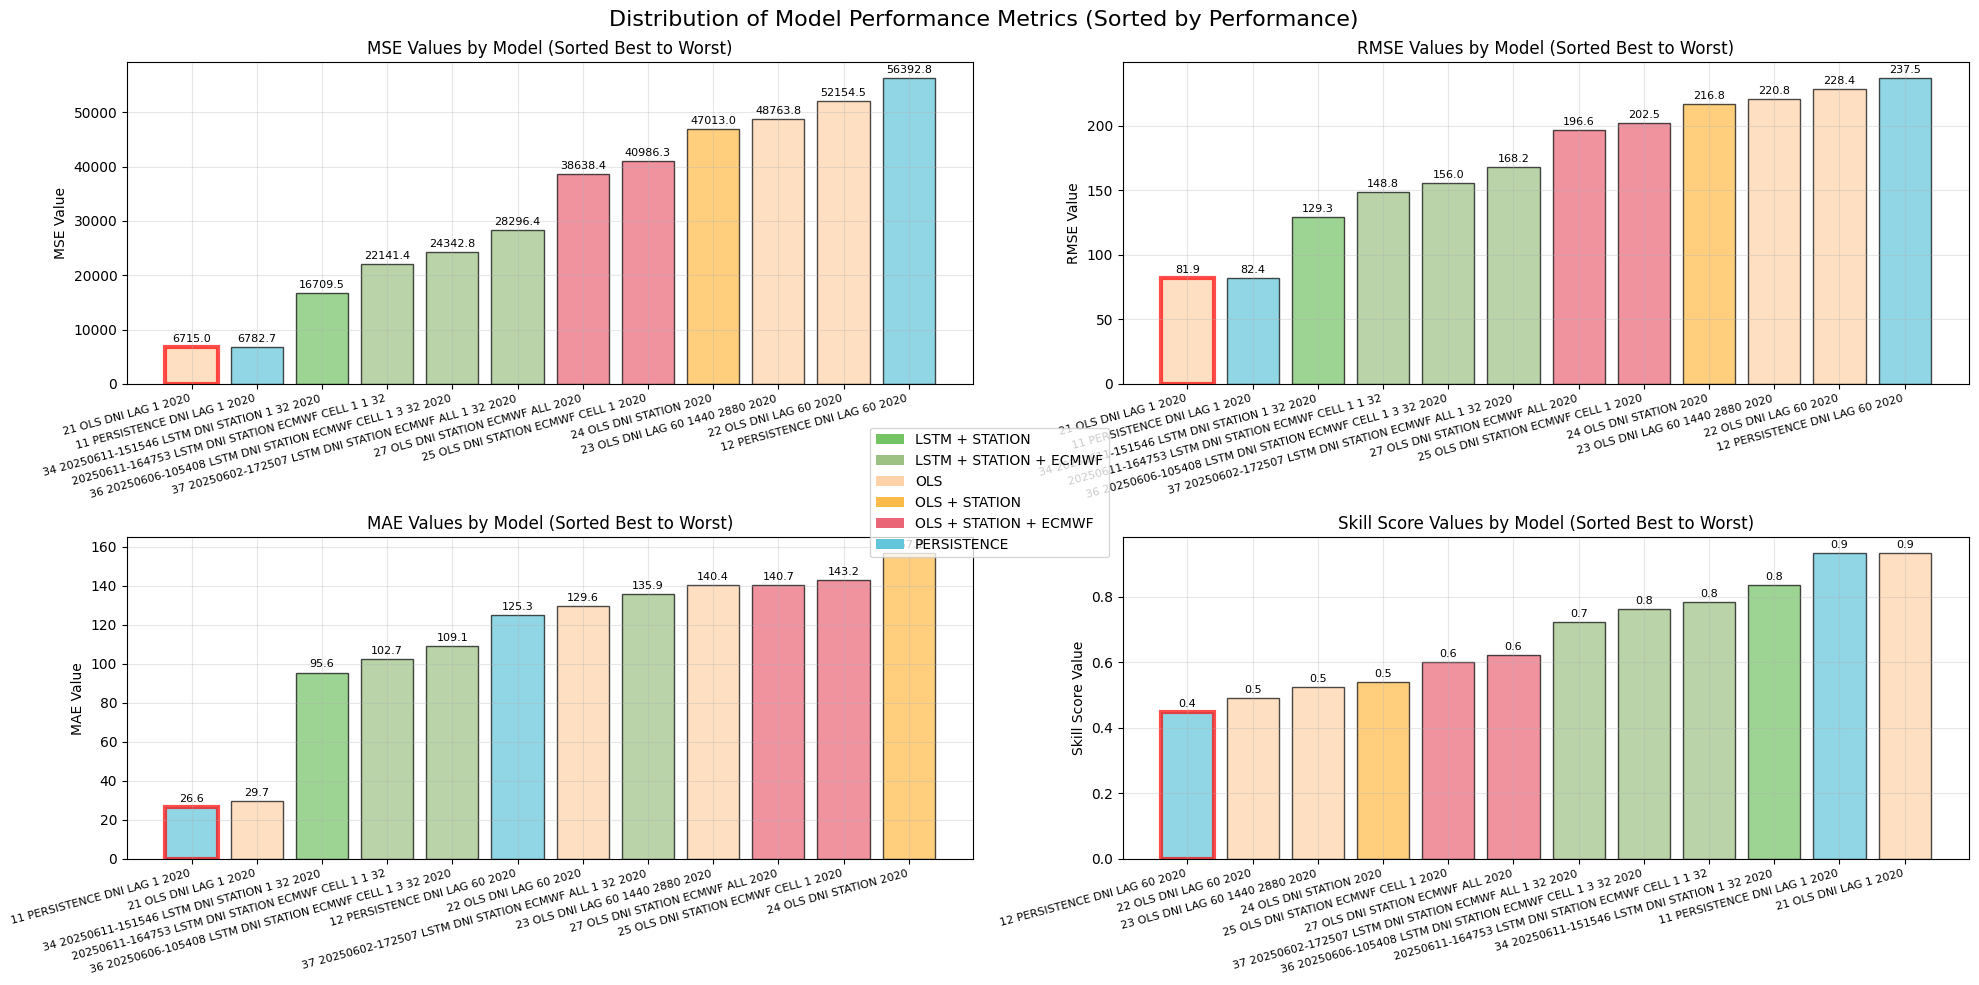

In [32]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

# Sort the dataframe by each metric for better visualization
sorted_dfs = {}
for metric in ['MSE', 'RMSE', 'MAE', 'Skill Score']:
    sorted_dfs[metric] = report_df.sort_values(by=metric, ascending=True).copy()


# Create histograms for MSE, RMSE, MAE, and MAPE showing error values
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Distribution of Model Performance Metrics (Sorted by Performance)', fontsize=16)

metrics = ['MSE', 'RMSE', 'MAE', 'Skill Score']

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    
    # Get sorted data for this metric
    sorted_df = sorted_dfs[metric]
    values = sorted_df[metric].values
    model_labels = [' '.join(x.split('_')[:]) for x in sorted_df['Model'].values]
    
    # Create color list based on model type and ECMWF keyword
    colors = [x for x in sorted_df['Color'].values]
    
    # Create bar plot showing actual error values
    bars = axes[row, col].bar(range(len(values)), values, color=colors, alpha=0.7, edgecolor='black')
    
    axes[row, col].set_title(f'{metric} Values by Model (Sorted Best to Worst)')
    # axes[row, col].set_xlabel('Models (Sorted by Performance)')
    axes[row, col].set_ylabel(f'{metric} Value')
    axes[row, col].grid(True, alpha=0.3)
    
    # Set x-axis labels with model names
    axes[row, col].set_xticks(range(len(values)))
    axes[row, col].set_xticklabels(model_labels, rotation=15, ha='right', fontsize=8)
    
    # Add value labels on top of bars
    for j, (bar, value) in enumerate(zip(bars, values)):
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
                           f'{value:.1f}', ha='center', va='bottom', fontsize=8)
    
    # # Add statistics as text box
    # mean_val = values.mean()
    # std_val = values.std()
    # min_val = values.min()
    # max_val = values.max()
    
    # stats_text = f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}'
    # axes[row, col].text(0.02, 0.98, stats_text, transform=axes[row, col].transAxes, 
    #                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Highlight best performing model (first one since sorted)
    bars[0].set_edgecolor('red')
    bars[0].set_linewidth(3)

# Create legend for model types and ECMWF variants

uniques = set()
for row in report_df.itertuples():
    uniques.add((row.Color, row.Label))
    
# sort the unique colors and labels
uniques = sorted(uniques, key=lambda x: x[1])  # Sort by label for consistent order
legend_elements = [Patch(facecolor=color, label=label) for color, label in uniques]

fig.legend(handles=legend_elements, loc="center")

plt.tight_layout()
# plt.savefig('./thesis_content/model_performance_metrics.png', dpi=100)
plt.show()

In [38]:
# comparsion.df['37_20250602-172507_LSTM_DNI_STATION_ECMWF_ALL_1_32_2020']
model_1 = '34_20250611-151546_LSTM_DNI_STATION_1_32_2020'
model_2 = '27_OLS_DNI_STATION_ECMWF_ALL_2020'
model_3 = '37_20250602-172507_LSTM_DNI_STATION_ECMWF_ALL_1_32_2020'
diff = comparsion.df[model_1] - comparsion.df[model_2]
diff.sort_values(ascending=False, inplace=True)
diff

2024-04-29 09:22:00    640.974095
2024-04-22 06:40:00    597.691363
2024-05-09 07:28:00    594.632117
2024-04-22 06:38:00    594.004242
2024-04-22 06:36:00    592.638414
                          ...    
2024-05-19 09:25:00   -680.299937
2024-04-16 12:52:00   -684.515696
2024-04-16 12:56:00   -689.349956
2024-04-16 12:50:00   -691.389820
2024-05-19 09:33:00   -697.223364
Length: 222720, dtype: float64

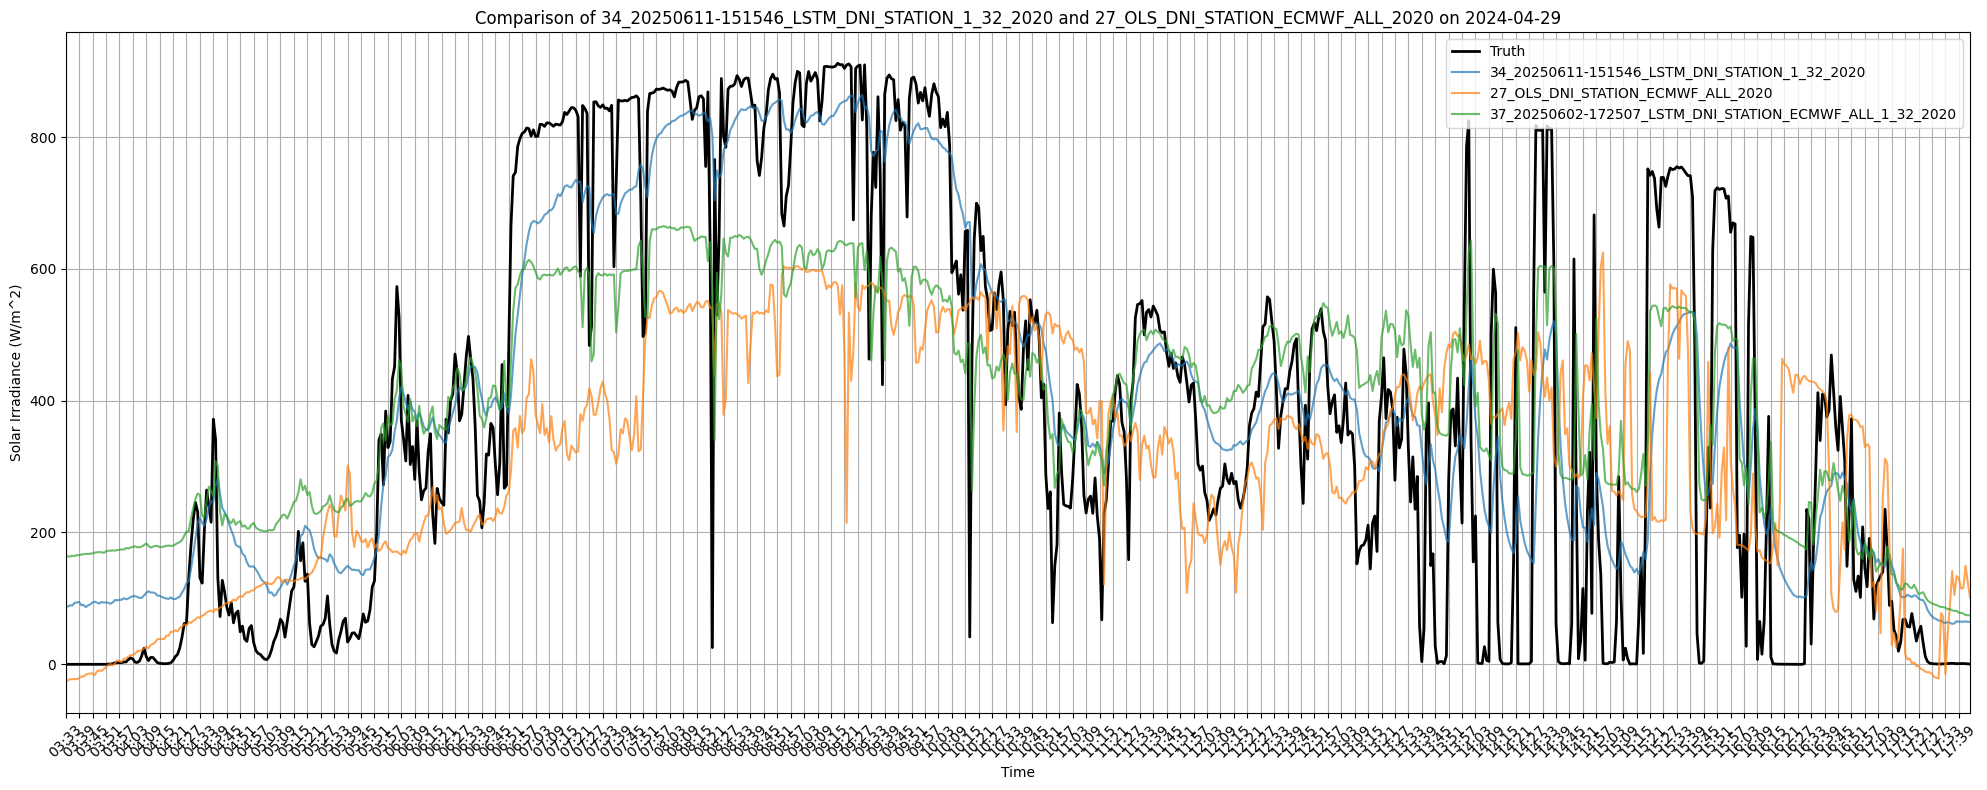

In [39]:
comparison_day = diff.index[0].strftime('%Y-%m-%d')
m1 = comparsion.df[model_1].loc[comparison_day]
m2 = comparsion.df[model_2].loc[comparison_day]
m3 = comparsion.df[model_3].loc[comparison_day]
truth = comparsion.truth.loc[comparison_day]
plt.figure(figsize=(20, 8))
plt.plot(truth.index, truth.values, label='Truth', color='black', linewidth=2)
plt.plot(m1.index, m1.values, label=model_1, alpha=0.7)
plt.plot(m2.index, m2.values, label=model_2, alpha=0.7)
plt.plot(m3.index, m3.values, label=model_3, alpha=0.7)
plt.title(f'Comparison of {model_1} and {model_2} on {comparison_day}')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance (W/m^2)')
plt.xticks(rotation=45)
# human readable x-axis in format HH:MM
plt.xticks(truth.index[::6], [t.strftime('%H:%M') for t in truth.index[::6]], rotation=45)
# limit x-axis to the range of the truth data
plt.xlim(truth.index.min(), truth.index.max())
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

